# Ultrasound Nerve Segmentation

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, glob, math, cv2, time
import numpy as np
import sys
import re
import csv
from tensorflow.contrib import slim
from tensorflow.contrib.layers.python.layers import layers
from scipy.misc import imresize

%matplotlib inline

First, let's load the training data, images will be resized to 128x128 and will later be converted to TFrecords format so we dont need to hold them into memory.

In [2]:
train_path='.../train/' #path where the training images are
test_path='.../test/' #path to where the testing images are
record_path='.../tfrecords/' #where the TFrecords will be saved
tensorb_path='.../events/'#where the tensorboard events will be saved
ckpt_path=".../checkpoints/" #where checkpoints will be saved

In [3]:
height=128  #original size : 420*580
width=128
def process_image(img_file):  
 "rezize images"
 img = cv2.imread(img_file,1)
 img = (cv2.resize(img,(height,width)).astype('uint8'))
 img = (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
 return img

def load_training():
 start = time.time()
 id_patient=[]
 X_train=[] 
 Y_train=[]

 print('Loading training data')
 path = train_path+'*[0-9].tif'
 files = glob.glob(path)
 for im_file in files:
  id_patient.append(os.path.basename(im_file).split('_')[0])
  img=process_image(im_file)
  mask=os.path.splitext(im_file)[0]+'_mask.tif'
  X_train.append(img)
  imgmask= process_image(mask)
  Y_train.append(imgmask)   
 
 end = time.time() - start
 print("Number of training examples : %.4r" % (len(X_train)))
 print("Time: %.2f seconds" % end)
 X_train=np.asarray(X_train)
 Y_train=np.asarray(Y_train)
 return X_train,Y_train,id_patient


def load_testing():
 start = time.time()
 test=[]
 idtest=[]
 print('Loading testing data')
 path = test_path+'*.tif'
 files = glob.glob(path)
 for im_file in files:
  img=process_image(im_file)
  test.append(img)
  idtest.append((im_file.split('/')[-1].split('.')[0]))
 end = time.time() - start
 print("Number of testing examples : %.4r" % (len(test)))
 print("Time: %.2f seconds" % end)
 test=np.asarray(test)
 return test,idtest

def show_image_and_mask(idx):
    """ Displays a training image and the mask. """
    im = X[idx]
    plt.subplot(121)
    plt.imshow(im,cmap="gray")

    mask = Y[idx]
    plt.subplot(122)
    plt.imshow(mask,cmap="gray")

In [79]:
X,Y,id_patient=load_training()

Loading training data
Number of training examples : 5635
Time: 103.16 seconds


In [124]:
test,idtest=load_testing()

Loading testing data
Number of testing examples : 5508
Time: 62.50 seconds


This is what our images looks like

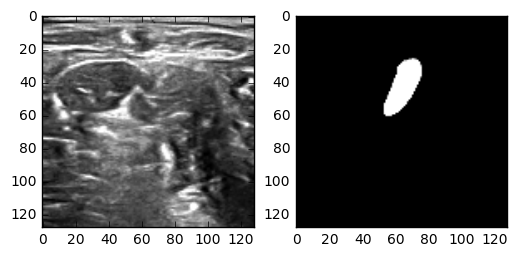

In [10]:
show_image_and_mask(42)

Now we split the images into training and validation sets. We want to split on patients rather than randomly to avoid overfitting. There are 47 patients, each have either 119 or 120 images. We takes 39 patients as training and the remaining 8 as validation

In [80]:
Xtrain=X[0:4552]
Ytrain=Y[0:4552]
Xvalid=X[4552:]
Yvalid=Y[4552:]

Let's convert them to TFrecords format

In [4]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to(images,masks,name):
  num_examples = images.shape[0]
  rows = images.shape[1]
  cols = images.shape[2]
  depth = 1

  filename = os.path.join(record_path, name + '.tfrecords')
  print('Writing', filename)
  writer = tf.python_io.TFRecordWriter(filename)
  for index in range(num_examples):
    image_raw = images[index].tostring()
    mask_raw=masks[index].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(rows),
        'width': _int64_feature(cols),
        'depth': _int64_feature(depth),
        'image_raw': _bytes_feature(image_raw),
        'mask_raw': _bytes_feature(mask_raw)}))
    writer.write(example.SerializeToString())
  writer.close()

def convert_topred(images,idtest,name):
  num_examples = images.shape[0]
  rows = images.shape[1]
  cols = images.shape[2]
  depth = 1

  filename = os.path.join(record_path, name + '.tfrecords')
  print('Writing', filename)
  writer = tf.python_io.TFRecordWriter(filename)
  for index in range(num_examples):
    image_raw = images[index].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(rows),
        'width': _int64_feature(cols),
        'depth': _int64_feature(depth),
        'image_raw': _bytes_feature(image_raw),
        'idtest': _int64_feature(int(idtest[index]))}))
    writer.write(example.SerializeToString())
  writer.close()

In [48]:
convert_to(Xtrain,Ytrain,'trainrecord')
convert_to(Xvalid,Yvalid,'validrecord')
convert_topred(test,idtest,'testrecord')

('Writing', '/media/florian/My Passport/git/trainrecord.tfrecords')
('Writing', '/media/florian/My Passport/git/validrecord.tfrecords')
('Writing', '/media/florian/My Passport/git/testrecord.tfrecords')


In [127]:
convert_topred(test,idtest,'testrecord')

('Writing', '/media/florian/My Passport/git/testrecord.tfrecords')


In [49]:
del X,Y,test,Xtrain,Ytrain,Xvalid,Yvalid

Now we have our data as TFrecords , we need to be able to read and decode them

In [5]:
def read_and_decode(filename_queue):
  reader = tf.TFRecordReader()
  _, serialized_example = reader.read(filename_queue)
  features = tf.parse_single_example(
      serialized_example,
      features={
          'image_raw': tf.FixedLenFeature([], tf.string),
          'mask_raw':tf.FixedLenFeature([], tf.string)})

 
  image = tf.decode_raw(features['image_raw'], tf.uint8)
  image = tf.reshape(image, [height,width])
 
  mask=tf.decode_raw(features['mask_raw'], tf.uint8)
  mask = tf.reshape(mask, [height,width])

  # Convert from [0, 255] -> [-0.5, 0.5] floats.
  image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
  
  #Convert from [0, 255] -> [0, 1] floats.
  mask=tf.cast(mask, tf.float32) * (1. / 255)
  return image,mask

def read_and_decode_pred(filename_queue):
  reader = tf.TFRecordReader()
  _, serialized_example = reader.read(filename_queue)
  features = tf.parse_single_example(
      serialized_example,
      features={
          'image_raw': tf.FixedLenFeature([], tf.string),
          'idtest': tf.FixedLenFeature([], tf.int64)})

 
  image = tf.decode_raw(features['image_raw'], tf.uint8)
  image = tf.reshape(image, [height,width])
 
 # Convert from [0, 255] -> [-0.5, 0.5] floats.
  image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
  idtest = tf.cast(features['idtest'], tf.int32)
  return image,idtest

To improve the network's performance we make use of data augmentation,when the images are loaded they are randomly flipped vertically and/or horizontaly ,there are already built-in functions to do that in tensorflow, but they take only one image at a time,this is fine for  classficiation problems where the target of an input is just a number (the class) but not for segmentation problems where the target of an input is another image, we need to make sure the input and the target are distorted the same way,the next function is there to do that (credit to "mtourne" on stackoverflow) 

In [6]:
def image_distortions(image, distortions):
    distort_left_right_random = distortions[0]
    mirror = tf.less(tf.pack([1.0, distort_left_right_random, 1.0]), 0.5)
    image = tf.reverse(image, mirror)
    distort_up_down_random = distortions[1]
    mirror = tf.less(tf.pack([distort_up_down_random, 1.0, 1.0]), 0.5)
    image = tf.reverse(image, mirror)
    return image

In [7]:
def distorted_inputs(batch_size, num_epochs):
  """Construct distorted input for  training"""
  if not num_epochs: num_epochs = None
  filename =record_path+ 'trainrecord.tfrecords'

  with tf.name_scope('input'):
    filename_queue = tf.train.string_input_producer(
        [filename], num_epochs=num_epochs)

    image,mask= read_and_decode(filename_queue)
    
  image= tf.reshape(image, [height,width,1])
  mask=tf.reshape(mask, [height,width,1])
  
  distortions = tf.random_uniform([2], 0, 1.0, dtype=tf.float32)
  image = image_distortions(image, distortions)
  mask = image_distortions(mask, distortions)# image and mask will be distorted the same way

    # Shuffle the examples and collect them into batch_size batches.
    # (Internally uses a RandomShuffleQueue.)
    # We run this in two threads to avoid being a bottleneck.
  with tf.device('/cpu:0'):
     images, masks = tf.train.shuffle_batch(
        [image,mask], batch_size=batch_size, num_threads=2,
        capacity=1000 + 3 * batch_size,allow_smaller_final_batch=False,
        # Ensures a minimum amount of shuffling of examples.
        min_after_dequeue=1000)
  tf.image_summary('image', images,max_images=2) #This will show the images on TensorBoard
  tf.image_summary('mask', masks,max_images=2)
  masks=tf.cast(masks, tf.int64)  
  return images,masks

In [8]:
def inputs(train, batch_size, num_epochs):
  """same as the previous function but images are not distorted (for evaluation)"""
  if train==True:
   filename = record_path+'trainrecord.tfrecords'
  else:
   filename = record_path+'validrecord.tfrecords'
      

  with tf.name_scope('input'):
    filename_queue = tf.train.string_input_producer(
        [filename], num_epochs=num_epochs)
    image,mask= read_and_decode(filename_queue)
  
  image=tf.reshape(image, [height,width,1])
  mask=tf.reshape(mask, [height,width,1])  

  with tf.device('/cpu:0'):
     images, masks = tf.train.batch(
        [image,mask], batch_size=batch_size, num_threads=2,
        capacity=1000 + 3 * batch_size,allow_smaller_final_batch=False)
  tf.image_summary('image', images,max_images=2)
  tf.image_summary('mask', masks,max_images=2)
  masks=tf.cast(masks, tf.int64) 
  return images,masks

def inputs_topred(batch_size, num_epochs):
    filename = record_path+'testrecord.tfrecords'
    with tf.name_scope('input'):
        filename_queue = tf.train.string_input_producer(
        [filename], num_epochs=num_epochs)
        image,idtest=read_and_decode_pred(filename_queue)
        image=tf.reshape(image, [height,width,1])
    with tf.device('/cpu:0'):
     images,idtests = tf.train.batch(
     [image,idtest],batch_size=batch_size, num_threads=1,allow_smaller_final_batch=True,capacity=1000 + 3 * batch_size)
     return images,idtests

Now we define the network architecture using TensorFlow-Slim 

In [9]:
def inference(data,is_training,batch_norm,scope=''):
  prob=0.60
  with slim.arg_scope([slim.conv2d], padding='SAME', normalizer_fn=slim.batch_norm,
                     normalizer_params={'decay': 0.9997,'is_training':batch_norm,'updates_collections':None,
                     'trainable':is_training},
                      weights_initializer=slim.initializers.xavier_initializer()
                     ,weights_regularizer=slim.l2_regularizer(0.0005)):    
    
    conv1 = slim.repeat(data, 2, slim.conv2d, 32, [3, 3], scope='conv1')
    conv1 = slim.dropout(conv1, prob,is_training=is_training,scope='dropout1')
    pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1') # 64
    conv2 = slim.repeat(pool1, 2, slim.conv2d, 64, [3, 3], scope='conv2')
    conv2 = slim.dropout(conv2, prob,is_training=is_training,scope='dropout2')
    pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2') # 32
    conv3 = slim.repeat(pool2, 2, slim.conv2d, 128, [3, 3], scope='conv3')
    conv3 = slim.dropout(conv3, prob,is_training=is_training,scope='dropout3')
    pool3 = slim.max_pool2d(conv3, [2, 2], scope='pool3') # 16
    conv4 = slim.repeat(pool3, 2, slim.conv2d, 256, [3, 3], scope='conv4')
    conv4 = slim.dropout(conv4, prob,is_training=is_training,scope='dropout4')
    pool4 = slim.max_pool2d(conv4, [2, 2], scope='pool4')#8
    conv5 = slim.repeat(pool4, 2, slim.conv2d, 512, [3, 3], scope='conv5')
    conv5 = slim.dropout(conv5, prob,is_training=is_training,scope='dropout5')

  with slim.arg_scope([slim.conv2d,slim.conv2d_transpose], padding='SAME',
                     normalizer_fn=slim.batch_norm,
                     normalizer_params={'decay': 0.9997,'is_training':batch_norm,'updates_collections':None,
                    'trainable':is_training},
                     weights_initializer=slim.initializers.xavier_initializer(),
                     weights_regularizer=slim.l2_regularizer(0.0005)):
    
    deconv1=slim.conv2d_transpose(conv5,512,stride=2,kernel_size=2) #16
    deconv1 = slim.dropout(deconv1, prob,is_training=is_training,scope='d_dropout1')
    concat1=tf.concat(3,[conv4,deconv1],name='concat1')
    conv6 = slim.repeat(concat1, 2, slim.conv2d, 256, [3, 3], scope='conv6')  
    conv6 = slim.dropout(conv6, prob,is_training=is_training,scope='dropout6')
    deconv2=slim.conv2d_transpose(conv6,256,stride=2,kernel_size=2) #32
    deconv2 = slim.dropout(deconv2, prob,is_training=is_training,scope='d_dropout2')
    concat2=tf.concat(3,[conv3,deconv2],name='concat2')   
    conv7 = slim.repeat(concat2, 2, slim.conv2d,128, [3, 3], scope='conv7')
    conv7 = slim.dropout(conv7, prob,is_training=is_training,scope='dropout7')
    deconv3=slim.conv2d_transpose(conv7,128,stride=2,kernel_size=2) #64
    deconv3 = slim.dropout(deconv3, prob,is_training=is_training,scope='d_dropout3')
    concat3=tf.concat(3,[conv2,deconv3],name='concat3')
    conv8 = slim.repeat(concat3, 2, slim.conv2d, 64, [3, 3], scope='conv8')
    conv8 = slim.dropout(conv8, prob,is_training=is_training,scope='dropout8')
    deconv4=slim.conv2d_transpose(conv8,64,stride=2,kernel_size=2) #128
    deconv4 = slim.dropout(deconv4, prob,is_training=is_training,scope='d_dropout4')
    concat4=tf.concat(3,[conv1,deconv4],name='concat4')
    conv9 = slim.repeat(concat4, 2, slim.conv2d, 32, [3, 3], scope='conv9')
    conv9 = slim.dropout(conv9, prob,is_training=is_training,scope='dropout9')
    conv1x1=slim.conv2d(conv9, 2, [1, 1],  activation_fn=tf.nn.sigmoid,scope='conv1x1')
  
  return conv1x1

In [10]:
def dice_coef(y_true, y_pred):
    """Compute the mean(batch-wise) of dice coefficients"""
    md=tf.constant(0.0)
    y_true=tf.cast(y_true, tf.float32)
    y_true_f = slim.flatten(y_true)
    y_pred_f = slim.flatten(y_pred)
    for i in xrange(batch_size):
     union=tf.reduce_sum(y_true_f[i]) + tf.reduce_sum(y_pred_f[i]) 
     md = tf.cond(tf.equal(union,0.0), lambda: tf.add(md,1.0), 
                 lambda: tf.add(md,tf.div(2.*tf.reduce_sum(tf.mul(y_true_f[i],y_pred_f[i])),union))) 

    return tf.div(md,batch_size)

We can now start the training

In [11]:
num_epochs=55
batch_size=24

def train():
  
  with tf.Graph().as_default():
  
    images, masks =distorted_inputs(batch_size=batch_size,num_epochs=num_epochs)
    masks=tf.reshape(masks,[batch_size,height,width], name=None)
    logits=inference(images,is_training=True,batch_norm=True)
    
    
    pred=tf.argmax(logits, dimension=3)
    pred=tf.reshape(pred, [batch_size,height,width,1])
    pred=tf.cast(pred, tf.float32)
    tf.image_summary('predicted', pred,max_images=2) # This will display predicted images in tensorboard
    
    class_weight = tf.constant([0.75,0.25])
    weighted_logits =tf.mul(logits, class_weight) 
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(weighted_logits, masks)
    
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    dice=dice_coef(masks,pred)
    
    tf.scalar_summary('loss', loss)#tensorboard will keep track of loss and dice during training
    tf.scalar_summary('dice', dice)


    train_op=tf.train.AdamOptimizer(learning_rate=0.0005, beta1=0.9, beta2=0.999,
                                  epsilon=1e-08, use_locking=False).minimize(loss)
    



    # Build the summary operation based on the TF collection of Summaries.
    tf.add_to_collection('train_op', train_op)
    saver = tf.train.Saver(tf.all_variables())
    summary_op = tf.merge_all_summaries()
    # Build an initialization operation to run below.
    init = tf.group(tf.initialize_all_variables(),
                    tf.initialize_local_variables())
    


    # Start running operations on the Graph.
    sess = tf.Session(config=tf.ConfigProto(
        log_device_placement=False))
    sess.run(init)
   
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    summary_writer = tf.train.SummaryWriter(tensorb_path, sess.graph)
    try: 
      step = 0
      while not coord.should_stop():
          
    
        start_time = time.time()
        _, loss_value,dice_value= sess.run([train_op, loss,dice])
        
        duration = time.time() - start_time
        if step % 10 == 0:
          
          #print('Step %d: loss = %.10f (%.3f sec) dice=%.2f' % (step, loss_value,duration,dice_value))
          summary_str = sess.run(summary_op)
          summary_writer.add_summary(summary_str, step)
        if step % 1000 == 0 :
         saver.save(sess,ckpt_path+ 'model.ckpt',step) #makes a checkpoint every 1000 step       
        if step % 100==0:
         print('Step %d: loss = %.5f dice=%.2f (%.3f sec) ' % (step, loss_value,dice_value,duration))   
        step += 1
    except tf.errors.OutOfRangeError:
      print('Done training for %d epochs, %d steps.' % (num_epochs, step))
    finally:
      # When done, ask the threads to stop.
      coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()


In [20]:
train()

Step 0: loss = 0.58497 dice=0.02 (4.481 sec) 
Step 100: loss = 0.56066 dice=0.07 (0.836 sec) 
Step 200: loss = 0.55534 dice=0.11 (0.839 sec) 
Step 300: loss = 0.54780 dice=0.34 (0.839 sec) 
Step 400: loss = 0.54458 dice=0.11 (0.836 sec) 
Step 500: loss = 0.53950 dice=0.22 (0.838 sec) 
Step 600: loss = 0.53494 dice=0.26 (0.900 sec) 
Step 700: loss = 0.52935 dice=0.48 (0.838 sec) 
Step 800: loss = 0.52610 dice=0.17 (0.835 sec) 
Step 900: loss = 0.52185 dice=0.43 (0.839 sec) 
Step 1000: loss = 0.51742 dice=0.45 (0.855 sec) 
Step 1100: loss = 0.51179 dice=0.53 (0.848 sec) 
Step 1200: loss = 0.50924 dice=0.38 (0.874 sec) 
Step 1300: loss = 0.50423 dice=0.66 (0.875 sec) 
Step 1400: loss = 0.50147 dice=0.49 (0.874 sec) 
Step 1500: loss = 0.49834 dice=0.35 (0.870 sec) 
Step 1600: loss = 0.49523 dice=0.55 (0.876 sec) 
Step 1700: loss = 0.49250 dice=0.50 (0.867 sec) 
Step 1800: loss = 0.48814 dice=0.38 (0.846 sec) 
Step 1900: loss = 0.48444 dice=0.48 (0.885 sec) 
Step 2000: loss = 0.48213 dice=0

In [12]:
def eval_once(saver,loss,dice,summary_writer, summary_op):
  num_examples=1082
  with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(ckpt_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    sess.run(tf.initialize_local_variables()) 
    # Start the queue runners.
    coord = tf.train.Coordinator()
    try:
      threads = []
      for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
        threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
                                         start=True))

      num_iter=int(math.ceil(num_examples /batch_size))
      step=0
      mdice=[]
      while step < num_iter and not coord.should_stop():
        loss_value,dice_value = sess.run([loss,dice])
        mdice.append(dice_value)
        if step % 5==0: 
         summary_str = sess.run(summary_op)
         summary_writer.add_summary(summary_str, step)
   
        
        if step==num_iter-1:
         print('total dice = %.2f '% (np.mean(mdice))) 
        step+=1


    except Exception as e:  
      coord.request_stop(e)

    coord.request_stop()
    coord.join(threads, stop_grace_period_secs=10)
    

In [13]:
batch_size=24
def evaluate():
  """Evaluate model on Dataset for a number of steps."""
  with tf.Graph().as_default() as g:
    
    images, masks=inputs(train=False,batch_size=batch_size,num_epochs=None)
    masks=tf.reshape(masks,[batch_size,height,width], name=None)
    logits=inference(images,is_training=False,batch_norm=True)
    
    pred=tf.argmax(logits, dimension=3)
    pred=tf.reshape(pred, [batch_size,height,width,1])
    pred=tf.cast(pred, tf.float32)
    tf.image_summary('predicted', pred,max_images=2)
    
    class_weight = tf.constant([0.75,0.25])
    weighted_logits = tf.mul(logits, class_weight) 
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(weighted_logits, masks)
    
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    dice=dice_coef(masks,pred)
    
    tf.scalar_summary('loss', loss)
    tf.scalar_summary('dice', dice)
    
   

     #Build the summary operation based on the TF collection of Summaries.
    summary_op = tf.merge_all_summaries()
        
    saver = tf.train.Saver(tf.all_variables())
   
    summary_writer = tf.train.SummaryWriter(tensorb_path,g)
    while True:
      eval_once(saver,loss,dice,summary_writer,summary_op)
      #pred_once(saver,pred,summary_writer,summary_op)
      break
      

In [101]:
evaluate()

total dice = 0.65 


In [11]:
def pred_once(saver,pred,imds):
   num_examples=5508
   predset=[]
   with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(ckpt_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    sess.run(tf.initialize_local_variables()) 
    coord = tf.train.Coordinator()
    try:
      threads = []
      for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
        threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
                                         start=True))

      num_iter=int(math.ceil(num_examples /batch_size))
      step=0
      
      while step < num_iter and not coord.should_stop():
        predictions,idx = sess.run([pred,imds])
        predictions = np.array(predictions)
        
        if step % 100==0:
            print'Predicting step %d out of %d ' %(step,num_iter)
        for i in xrange (batch_size):
            predset.append((predictions[i],idx[i]))
        step+=1
      print("saving to disk")
      np.save("/media/florian/My Passport/git/pred", predset, allow_pickle=True)
    except Exception as e:  
      coord.request_stop(e)

    coord.request_stop()
    coord.join(threads, stop_grace_period_secs=10)

In [12]:
batch_size=12
def pred():
  """Evaluate model on Dataset for a number of steps."""
  with tf.Graph().as_default() as g:
    
    images,imds=inputs_topred(batch_size=batch_size,num_epochs=1)
    logits=inference(images,is_training=False,batch_norm=True)
    pred=tf.argmax(logits, dimension=3)
    saver = tf.train.Saver(tf.all_variables())
   
    while True:
      pred_once(saver,pred,imds)
      break
      time.sleep(60)

In [13]:
pred()

Predicting step 0 out of 459 
Predicting step 100 out of 459 
Predicting step 200 out of 459 
Predicting step 300 out of 459 
Predicting step 400 out of 459 
saving to disk


Let's load our predictions see and what they look like.

In [18]:
predictions=np.load("/media/florian/My Passport/git/pred.npy")

In [17]:
del predictions

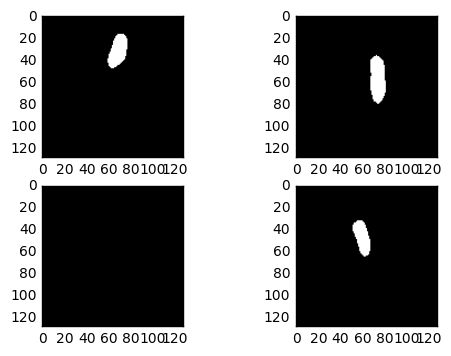

In [16]:
plt.subplot(221)
plt.imshow(predictions[6][0],cmap="gray")
plt.subplot(222)
plt.imshow(predictions[60][0],cmap="gray")
plt.subplot(223)
plt.imshow(predictions[15][0],cmap="gray")
plt.subplot(224)
plt.imshow(predictions[3605][0],cmap="gray")

But the original size of the images was 420x580, so let's resize our predictions 

In [22]:
fpred=[]
for i in xrange(len(predictions)):
 img=imresize((predictions[i][0]), (420,580))/255
 fpred.append((img,predictions[i][1]))

Then we do a little of post processing , any predicted image that has less than 3500 white pixels is set to a black image (no nerve).

In [23]:
allblack=np.zeros((420,580))

In [24]:
postpro=[]
for i in xrange(len(fpred)):
 if np.sum(fpred[i][0])<3500:
  postpro.append((allblack,fpred[i][1]))
 else:
  postpro.append((fpred[i][0],fpred[i][1]))     

In [26]:
def run_length_enc(label):
    '''run length encoder for submission'''
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

In [27]:
encpred=[]
for i in xrange(len(fpred)):
 encpred.append((postpro[i][1],run_length_enc(postpro[i][0])))
print('Done')

Done


In [29]:
with open('submissionUNS.csv','wb') as csvfile:
 writer=csv.writer(csvfile)
 length_list=len(encpred)
 writer.writerow(["img","pixels"])
 for i in xrange(length_list):    
    writer.writerow([encpred[i][0],encpred[i][1]])